Outlier dropped at index 3
Outlier dropped at index 5
Outlier dropped at index 6
Outlier dropped at index 8
Outlier dropped at index 12
split_index1: 267
split_index2: 1159
Pass 1 Winrates, len 741: ...[36.63500678426052, 36.58536585365854, 36.67117726657646, 36.62162162162162, 36.707152496626186]
Pass 2 Winrates, len 1281: ...[69.61628817541113, 69.56181533646323, 69.58561376075059, 69.609375, 69.63309914129586]
Pass 3 Winrates, len 1376: ...[77.98833819241983, 78.00436999271668, 78.02037845705968, 78.03636363636363, 78.05232558139535]
Overall Winrates, len 3398
Pass 1 average completion time: 129.23 seconds
Pass 2 average completion time: 56.04 seconds
Pass 3 average completion time: 46.02 seconds
Pass 1 average completion time for last 100 wins: 110.12 seconds
Pass 2 average completion time for last 100 wins: 54.25 seconds
Pass 3 average completion time for last 100 wins: 46.23 seconds


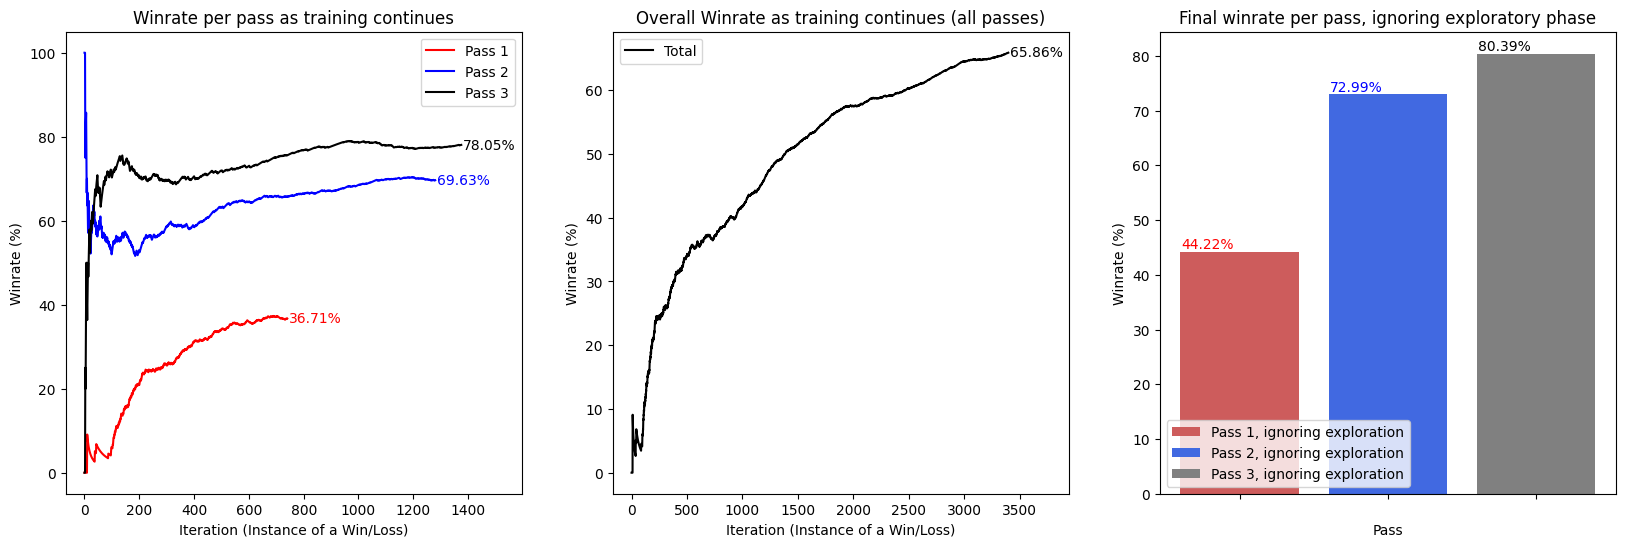

In [237]:
import pandas as pd                     # type: ignore
import matplotlib.pyplot as plt         # type: ignore
import matplotlib.gridspec as gridspec  # type: ignore

#Customization
p1_color = "red"
p2_color = "blue"
p3_color = "black"
p1_color_average = "indianred"
p2_color_average = "royalblue"
p3_color_average = "gray"
ignore_phase = 300  # Number of initial wins to ignore for winrate calculation
cutoff = 100          # Number of last wins to consider for average completion time

def convert_to_time(timesteps):
    tps = 80	# estimated value for timesteps per second
    return round(timesteps / tps, 2)

def label_bars(ax, bars, color, append=""):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/100.0, yval, f'{yval:.2f}{append}', va='bottom', color=color)

# Read the file and extract the win/losses
winloss_path = './logs/winloss.csv'
winloss = pd.read_csv(winloss_path, header=None, names=['WinLoss', 'Pass'])

# Calculate iterative winrate
p1_iter_wins, p2_iter_wins, p3_iter_wins, total_wins = 0, 0, 0, 0
p1_iter_losses, p2_iter_losses, p3_iter_losses, total_losses = 0, 0, 0,0
p1_iter_winlosses, p2_iter_winlosses, p3_iter_winlosses, total_iter_winlosses = [], [], [], []
p1_iter_wins_ignore, p2_iter_wins_ignore, p3_iter_wins_ignore = 0, 0, 0
p1_iter_losses_ignore, p2_iter_losses_ignore, p3_iter_losses_ignore = 0, 0, 0
p1_iter_winlosses_ignore, p2_iter_winlosses_ignore, p3_iter_winlosses_ignore = [], [], []
for index, row in winloss.iterrows():
    if row['WinLoss'] == 'win':
        if row['Pass'] == 1:
            p1_iter_wins += 1
            if index >= ignore_phase:
                p1_iter_wins_ignore += 1
        elif row['Pass'] == 2:
            p2_iter_wins += 1
            if index >= ignore_phase + p1_iter_wins + p1_iter_losses:
                p2_iter_wins_ignore += 1
        elif row['Pass'] == 3:
            p3_iter_wins += 1
            if index >= ignore_phase + p1_iter_wins + p1_iter_losses + p2_iter_wins + p2_iter_losses:
                p3_iter_wins_ignore += 1
        total_wins += 1
    elif row['WinLoss'] == 'loss':
        if row['Pass'] == 1:
            p1_iter_losses += 1
            if index >= ignore_phase:
                p1_iter_losses_ignore += 1
        elif row['Pass'] == 2:
            p2_iter_losses += 1
            if index >= ignore_phase + p1_iter_wins + p1_iter_losses:
                p2_iter_losses_ignore += 1
        elif row['Pass'] == 3:
            p3_iter_losses += 1
            if index >= ignore_phase + p1_iter_wins + p1_iter_losses + p2_iter_wins + p2_iter_losses:
                p3_iter_losses_ignore += 1
        total_losses += 1
    # Calculate winrate at this point and store it in the list
    if (p1_iter_wins + p1_iter_losses) > 0 and row['Pass'] == 1:
        p1_iter_winlosses.append(p1_iter_wins / (p1_iter_wins + p1_iter_losses) * 100)
    if (p2_iter_wins + p2_iter_losses) > 0 and row['Pass'] == 2:
        p2_iter_winlosses.append(p2_iter_wins / (p2_iter_wins + p2_iter_losses) * 100)
    if (p3_iter_wins + p3_iter_losses) > 0 and row['Pass'] == 3:
        p3_iter_winlosses.append(p3_iter_wins / (p3_iter_wins + p3_iter_losses) * 100)
    if (total_wins + total_losses) > 0:
        total_iter_winlosses.append(total_wins / (total_wins + total_losses) * 100)
    if (p1_iter_wins_ignore + p1_iter_losses_ignore) > 0 and row['Pass'] == 1:
        p1_iter_winlosses_ignore.append(p1_iter_wins_ignore / (p1_iter_wins_ignore + p1_iter_losses_ignore) * 100)
    if (p2_iter_wins_ignore + p2_iter_losses_ignore) > 0 and row['Pass'] == 2:
        p2_iter_winlosses_ignore.append(p2_iter_wins_ignore / (p2_iter_wins_ignore + p2_iter_losses_ignore) * 100)
    if (p3_iter_wins_ignore + p3_iter_losses_ignore) > 0 and row['Pass'] == 3:
        p3_iter_winlosses_ignore.append(p3_iter_wins_ignore / (p3_iter_wins_ignore + p3_iter_losses_ignore) * 100)

# Calculate final winrates
final_p1 = p1_iter_winlosses[-1] if p1_iter_winlosses else 0
final_p2 = p2_iter_winlosses[-1] if p2_iter_winlosses else 0
final_p3 = p3_iter_winlosses[-1] if p3_iter_winlosses else 0
final_overall = total_iter_winlosses[-1] if total_iter_winlosses else 0
# Final winrates ignoring the exploratory phase
final_p1_ignore = p1_iter_winlosses_ignore[-1] if p1_iter_winlosses_ignore else 0
final_p2_ignore = p2_iter_winlosses_ignore[-1] if p2_iter_winlosses_ignore else 0
final_p3_ignore = p3_iter_winlosses_ignore[-1] if p3_iter_winlosses_ignore else 0

# Plotting winrates
plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax0.set_title('Winrate per pass as training continues')
ax0.set_xlabel('Iteration (Instance of a Win/Loss)')
ax0.set_ylabel('Winrate (%)')
ax0.plot(p1_iter_winlosses, color=p1_color, label='Pass 1')
ax0.plot(p2_iter_winlosses, color=p2_color, label='Pass 2')
ax0.plot(p3_iter_winlosses, color=p3_color, label='Pass 3')
ax0.annotate(f'{final_p1:.2f}%', xy=(len(p1_iter_winlosses)-1, final_p1-1), xytext=(1, 0), textcoords='offset points', color=p1_color)
ax0.annotate(f'{final_p2:.2f}%', xy=(len(p2_iter_winlosses)-1, final_p2-1), xytext=(1, 0), textcoords='offset points', color=p2_color)
ax0.annotate(f'{final_p3:.2f}%', xy=(len(p3_iter_winlosses)-1, final_p3-1), xytext=(1, 0), textcoords='offset points', color=p3_color)
ax1.set_title('Overall Winrate as training continues (all passes)')
ax1.set_xlabel('Iteration (Instance of a Win/Loss)')
ax1.set_ylabel('Winrate (%)')
ax1.plot(total_iter_winlosses, color='black', label='Total')
ax1.annotate(f'{final_overall:.2f}%', xy=(len(total_iter_winlosses)-1, final_overall-0.5), xytext=(1, 0), textcoords='offset points', color='black', fontsize=10)
# Plotting winrates ignoring exploratory phase
ax2.set_title('Final winrate per pass, ignoring exploratory phase')
ax2.set_xlabel('Pass')
ax2.set_ylabel('Winrate (%)')
bar1 = ax2.bar(' ', final_p1_ignore, color=p1_color_average, label='Pass 1, ignoring exploration')
bar2 = ax2.bar('  ', final_p2_ignore, color=p2_color_average, label='Pass 2, ignoring exploration')
bar3 = ax2.bar('   ', final_p3_ignore, color=p3_color_average, label='Pass 3, ignoring exploration')
label_bars(ax2, bar1, p1_color, append="%")
label_bars(ax2, bar2, p2_color, append="%")
label_bars(ax2, bar3, p3_color, append="%")

# Read the file and extract the levelbeat
levelbeats_path = './logs/levelbeats.csv'
levelbeats = pd.read_csv(levelbeats_path, header=None, names=['completion_timesteps', 'training_timesteps', 'time_in_seconds'])

# Remove outliers from levelbeat, although keep in mind they do represent massive amounts of exploration at the beginning of training
dropped = 0
indexes = [index for index, win_time in enumerate(levelbeats['completion_timesteps']) if win_time > 150000]
for index in indexes:
    levelbeats = levelbeats.drop(index)
    print(f"Outlier dropped at index {index}")
    dropped += 1

# Find the split in the .csv between Pass 1 and Pass 2
with open(levelbeats_path, 'r') as file:
    lines = file.readlines()
split_index1 = lines.index('\n') - dropped
split_index2 = lines.index('\n', split_index1+1+dropped) - dropped -1


# Split the data corresponding to Pass 1 and Pass 2, find averages & 5 fastests
p1_completion_t = levelbeats['completion_timesteps'][:split_index1]
p2_completion_t = levelbeats['completion_timesteps'][split_index1:split_index2]
p3_completion_t = levelbeats['completion_timesteps'][split_index2:]
p1_training_t = levelbeats['training_timesteps'][:split_index1]
p2_training_t = levelbeats['training_timesteps'][split_index1:split_index2]
p3_training_t = levelbeats['training_timesteps'][split_index2:]

# Acquire split data
average_pass1 = convert_to_time(p1_completion_t[-cutoff:].mean())
average_pass2 = convert_to_time(p2_completion_t[-cutoff:].mean())
average_pass3 = convert_to_time(p3_completion_t[-cutoff:].mean())
fastest_pass1 = levelbeats[:split_index1].nsmallest(5, 'completion_timesteps')
fastest_pass2 = levelbeats[split_index1:split_index2].nsmallest(5, 'completion_timesteps')
fastest_pass3 = levelbeats[split_index2:].nsmallest(5, 'completion_timesteps')

# Use to ensure split indexes are correct
print("split_index1:", split_index1)
print("split_index2:", split_index2)

# Make sure dropping of indexes is correct
# print(p1_training_t)
# print(p2_training_t)
# print(p3_training_t)

# Print winrate info
print(f'Pass 1 Winrates, len {len(p1_iter_winlosses)}: ...{p1_iter_winlosses[-5:]}')
print(f'Pass 2 Winrates, len {len(p2_iter_winlosses)}: ...{p2_iter_winlosses[-5:]}')
print(f'Pass 3 Winrates, len {len(p3_iter_winlosses)}: ...{p3_iter_winlosses[-5:]}')
print(f'Overall Winrates, len {len(total_iter_winlosses)}')

# Print out the data about the averages
print(f"Pass 1 average completion time: {convert_to_time(p1_completion_t.mean())} seconds")
print(f"Pass 2 average completion time: {convert_to_time(p2_completion_t.mean())} seconds")
print(f"Pass 3 average completion time: {convert_to_time(p3_completion_t.mean())} seconds")
print(f"Pass 1 average completion time for last {cutoff} wins: {average_pass1} seconds")
print(f"Pass 2 average completion time for last {cutoff} wins: {average_pass2} seconds")
print(f"Pass 3 average completion time for last {cutoff} wins: {average_pass3} seconds")

for ax in [ax0, ax1]:
    x_left, x_right = ax.get_xlim()
    padding = (x_right - x_left) * 0.1  # 10% right padding
    ax.set_xlim(x_left, x_right + padding)
    ax.legend()
ax2.legend(loc='lower left')
plt.show()

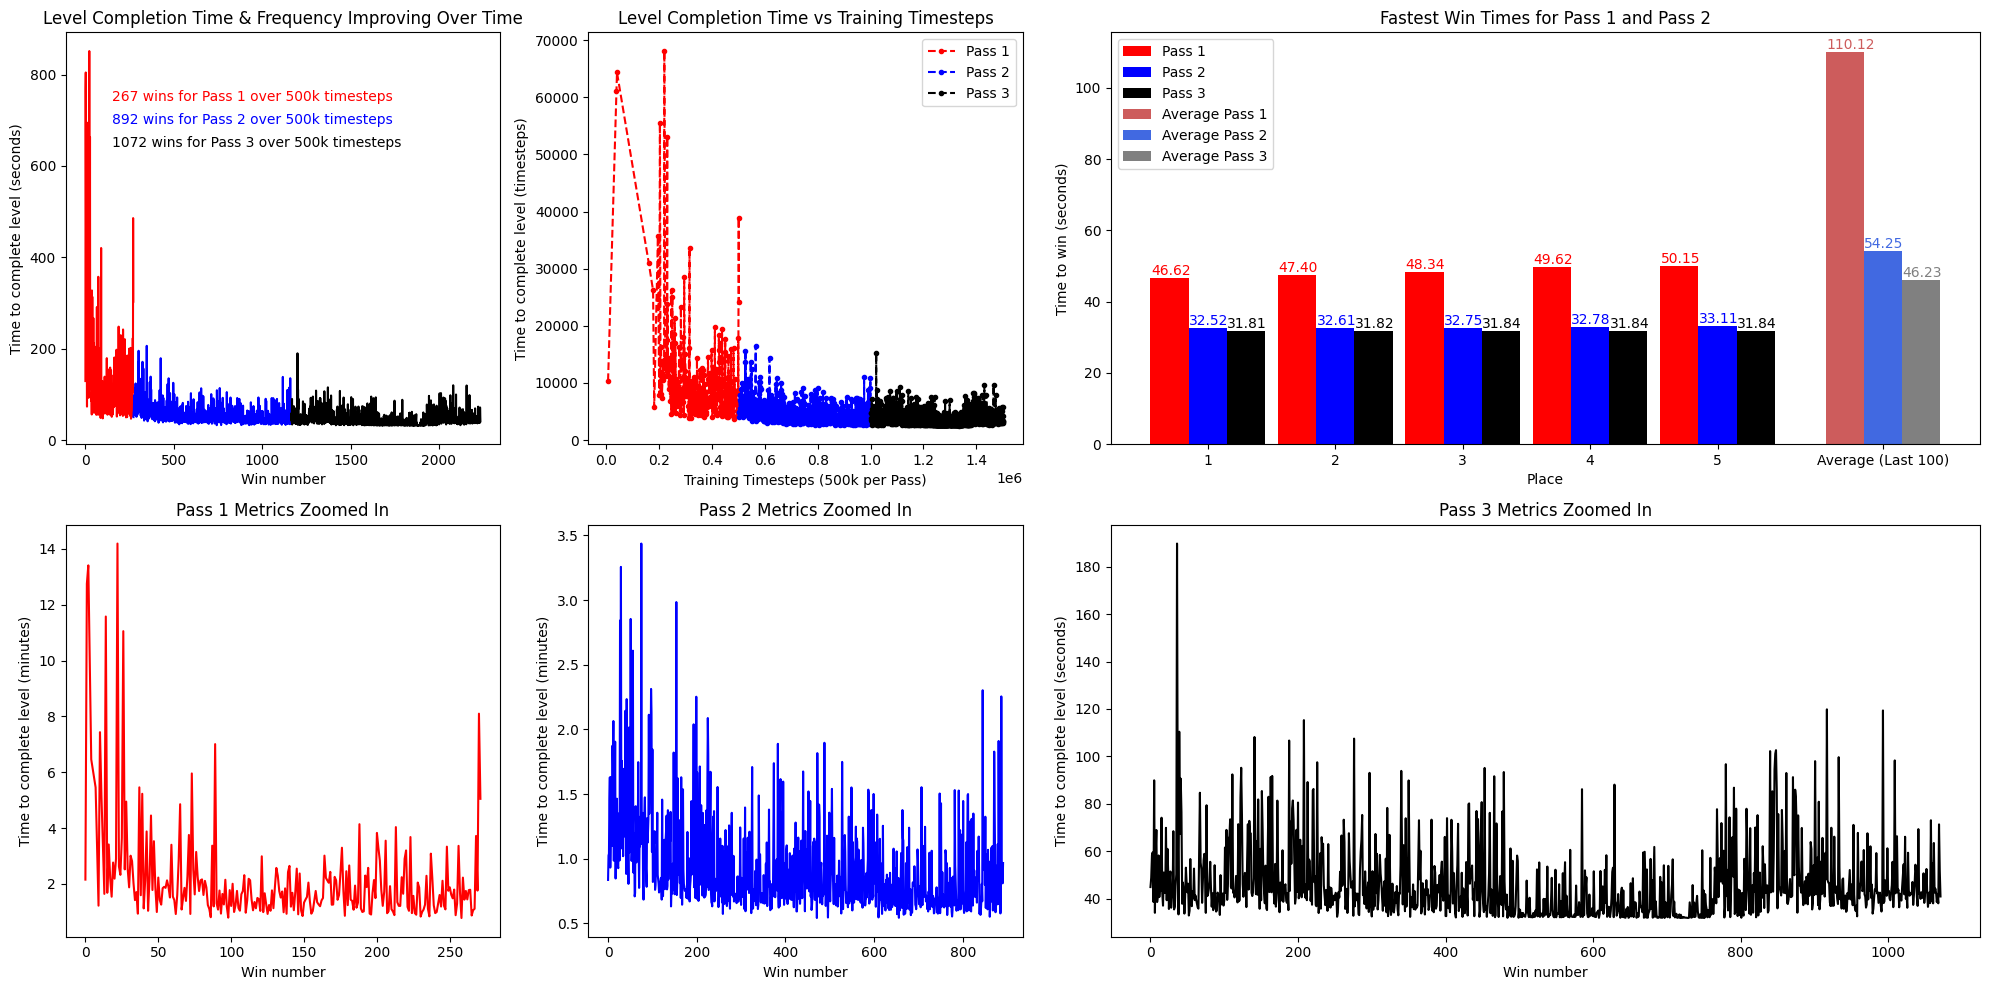

In [238]:
# Graph setup
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 2], height_ratios=[1, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])

# Graph level completion time and frequency improving over time
ax0.plot(convert_to_time(p1_completion_t), color=p1_color)
ax0.plot(convert_to_time(p2_completion_t), color=p2_color)
ax0.plot(convert_to_time(p3_completion_t), color=p3_color)
ax0.set_title('Level Completion Time & Frequency Improving Over Time')
ax0.set_ylabel('Time to complete level (seconds)')
ax0.set_xlabel('Win number')
ax0.text(150, 750, f'{len(p1_completion_t)} wins for Pass 1 over 500k timesteps', color=p1_color, verticalalignment='center', horizontalalignment='left')
ax0.text(150, 700, f'{len(p2_completion_t)} wins for Pass 2 over 500k timesteps', color=p2_color, verticalalignment='center', horizontalalignment='left')
ax0.text(150, 650, f'{len(p3_completion_t)} wins for Pass 3 over 500k timesteps', color=p3_color, verticalalignment='center', horizontalalignment='left')

# Graph level completion time vs training timesteps
ax1.plot(p1_training_t, p1_completion_t, linestyle='--', marker='.', label='Pass 1', color=p1_color)
ax1.plot(p2_training_t + 500000, p2_completion_t, linestyle='--', marker='.', label='Pass 2', color=p2_color)
ax1.plot(p3_training_t + 1000000, p3_completion_t, linestyle='--', marker='.', label='Pass 3', color=p3_color)
ax1.set_title('Level Completion Time vs Training Timesteps')
ax1.set_xlabel('Training Timesteps (500k per Pass)')
ax1.set_ylabel('Time to complete level (timesteps)')
ax1.legend(loc='upper right')

# Graph the bar chart, showing fastest speeds and average of the last 100 wins for each pass
width = 0.3
indices_pass1 = range(len(fastest_pass1))
indices_pass2 = [index + width for index in indices_pass1]
indices_pass3 = [index + width for index in indices_pass2]
bars1 =     ax2.bar(indices_pass1,                      convert_to_time(fastest_pass1['completion_timesteps']), width=width, label='Pass 1', color=p1_color)
bars2 =     ax2.bar(indices_pass2,                      convert_to_time(fastest_pass2['completion_timesteps']), width=width, label='Pass 2', color=p2_color)
bars3 =     ax2.bar(indices_pass3,                      convert_to_time(fastest_pass3['completion_timesteps']), width=width, label='Pass 3', color=p3_color)
bars1_avg = ax2.bar([max(indices_pass2) + 1],           [average_pass1],                                        width=width, label='Average Pass 1', color=p1_color_average)
bars2_avg = ax2.bar([max(indices_pass2) + 1 + width],   [average_pass2],                                        width=width, label='Average Pass 2', color=p2_color_average)
bars3_avg = ax2.bar([max(indices_pass3) + 1 + width],   [average_pass3],                                        width=width, label='Average Pass 3', color=p3_color_average)
label_bars(ax2, bars1, p1_color)
label_bars(ax2, bars2, p2_color)
label_bars(ax2, bars3, p3_color)
label_bars(ax2, bars1_avg, p1_color_average)
label_bars(ax2, bars2_avg, p2_color_average)
label_bars(ax2, bars3_avg, p3_color_average)
ax2.set_xticks(list(indices_pass2) + [max(indices_pass3) + 1])                          # Set x-ticks to indices and "Average" position
ax2.set_xticklabels(list(range(1, len(fastest_pass1) + 1)) + [f'Average (Last {cutoff})'])    # Set x-tick labels to index numbers and "Average"
ax2.set_title('Fastest Win Times for Pass 1 and Pass 2')
ax2.set_ylabel('Time to win (seconds)')
ax2.set_xlabel('Place')
ax2.legend()

# Graph the zoomed in metrics for each pass
ax3.plot(convert_to_time(p1_completion_t) / 60, color=p1_color)
ax3.set_title('Pass 1 Metrics Zoomed In')
ax3.set_ylabel('Time to complete level (minutes)')
ax3.set_xlabel('Win number')
x_values = range(len(convert_to_time(p2_completion_t)))
ax4.plot([x for x in x_values], convert_to_time(p2_completion_t) / 60, color=p2_color)
ax4.set_title('Pass 2 Metrics Zoomed In')
ax4.set_ylabel('Time to complete level (minutes)')
ax4.set_xlabel('Win number')
x_values = range(len(convert_to_time(p3_completion_t)))
ax5.plot([x for x in x_values], convert_to_time(p3_completion_t), color=p3_color)
ax5.set_title('Pass 3 Metrics Zoomed In')
ax5.set_ylabel('Time to complete level (seconds)')
ax5.set_xlabel('Win number')

# Show the graph
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()